# Import libraries

In [2]:
#Import libraries 
import os
import re
from sklearn.model_selection import StratifiedShuffleSplit
from keras.preprocessing.image import ImageDataGenerator

In [3]:
import pandas as pd
import random 
import shutil
from tqdm import tqdm
import PIL 
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np

In [4]:
DATASET = "D:/DOWNLOADS_EXEC/EuroSAT/2750/"

In [6]:
LABELS = os.listdir(DATASET)
print(LABELS)


['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [7]:
# Basic parameters 
TRAIN_DIR = "D:/DOWNLOADS_EXEC/EuroSAT/training/"
TEST_DIR = "D:/DOWNLOADS_EXEC/EuroSAT/testing/"
BATCH_SIZE = 64
NUM_CLASSES=len(LABELS)
INPUT_SHAPE = (64, 64, 3)
CLASS_MODE = 'categorical'

# Create training and testing directories
for path in (TRAIN_DIR, TEST_DIR):
    if not os.path.exists(path):
        os.mkdir(path)

# Create directories and move files 

In [8]:
# Create class label subdirectories in train and test
for l in LABELS:
    
    if not os.path.exists(os.path.join(TRAIN_DIR, l)):
        os.mkdir(os.path.join(TRAIN_DIR, l))

    if not os.path.exists(os.path.join(TEST_DIR, l)):
        os.mkdir(os.path.join(TEST_DIR, l))

In [9]:
# map each image path to their class label in 'data'
data = {}

for l in LABELS:
    for img in os.listdir(DATASET+'/'+l):
        data.update({os.path.join(DATASET, l, img): l})

X = pd.Series(list(data.keys()))
y = pd.get_dummies(pd.Series(data.values()))

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=69)

# split the list of image paths
for train_idx, test_idx in split.split(X, y):
    
    
    train_paths = X[train_idx]
    test_paths = X[test_idx]

    # define a new path for each image depending on training or testing
    new_train_paths = [re.sub("D:/DOWNLOADS_EXEC/EuroSAT/2750/", "D:/DOWNLOADS_EXEC/EuroSAT/training/", i) for i in train_paths]
    new_test_paths = [re.sub("D:/DOWNLOADS_EXEC/EuroSAT/2750/", "D:/DOWNLOADS_EXEC/EuroSAT/testing/", i) for i in test_paths]

    train_path_map = list((zip(train_paths, new_train_paths)))
    test_path_map = list((zip(test_paths, new_test_paths)))
    
    # move the files
    print("moving training files..")
    for i in tqdm(train_path_map):
        if not os.path.exists(i[1]):
            if not os.path.exists(re.sub('training', 'testing', i[1])):
                shutil.copy(i[0], i[1])
    
    print("moving testing files..")
    for i in tqdm(test_path_map):
        if not os.path.exists(i[1]):
            if not os.path.exists(re.sub('training', 'testing', i[1])):
                shutil.copy(i[0], i[1])

 18%|█▊        | 3966/21600 [00:00<00:00, 17968.72it/s]

moving training files..


 79%|███████▉  | 4267/5400 [00:00<00:00, 21812.65it/s]

moving testing files..


100%|██████████| 5400/5400 [00:00<00:00, 21104.01it/s]


In [11]:
 #Create a ImageDataGenerator Instance which can be used for data augmentation

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip = True
#   validation_split=0.2
)

train_generator = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    #subset='training',
    color_mode='rgb',
    shuffle=True,
    seed=69
)
# The validation set is optional if we choose to do that
"""
valid_generator = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    subset='validation',    
    color_mode='rgb',
    shuffle=True,
    seed=69
)
"""
# test generator for evaluation purposes with no augmentations, just rescaling
test_gen = ImageDataGenerator(
    rescale=1./255,
)

test_generator = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


In [12]:
print(train_generator.class_indices)

{'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


In [13]:
np.save('class_indices', train_generator.class_indices)

# Import libraries for  Neural networks


In [15]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam


from keras.applications import VGG16, VGG19
from keras.applications import ResNet50, ResNet50V2, ResNet152V2
from keras.applications import InceptionV3, Xception

from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, fbeta_score, accuracy_score

#### GPU use 

In [16]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")    
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)
    
tf.config.set_soft_device_placement(True)

#### COMPILE MODEL

In [17]:
def compile_model(cnn_base, input_shape, n_classes, optimizer, fine_tune=None):
    
    if (cnn_base == 'ResNet50') or (cnn_base == 'ResNet50V2') or (cnn_base == 'ResNet152V2'):
        if cnn_base == 'ResNet50':
            conv_base = ResNet50(include_top=False,
                                 weights='imagenet', 
                                 input_shape=input_shape)
        elif cnn_base == 'ResNet50V2':
            conv_base = ResNet50V2(include_top=False,
                                 weights='imagenet', 
                                 input_shape=input_shape)
        else:
            conv_base = ResNet152V2(include_top=False,
                                 weights='imagenet', 
                                 input_shape=input_shape)
        top_model = conv_base.output
        top_model = Flatten()(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = Dropout(0.2)(top_model)
       
    
    elif (cnn_base == 'VGG16') or (cnn_base == 'VGG19'):
        if cnn_base == 'VGG16':
            conv_base = VGG16(include_top=False,
                              weights='imagenet', 
                              input_shape=input_shape)
        else:
            conv_base = VGG19(include_top=False,
                              weights='imagenet', 
                              input_shape=input_shape)
        top_model = conv_base.output
        top_model = Flatten()(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = Dropout(0.2)(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = Dropout(0.2)(top_model)
    
    
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    model = Model(inputs=conv_base.input, outputs=output_layer)
        
    if type(fine_tune) == int:
        for layer in conv_base.layers[fine_tune:]:
            layer.trainable = True
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    model.compile(optimizer=optimizer, loss='categorical_crossentropy',
                 metrics=['categorical_accuracy'])
    
    return model

### PLOT HISTORY

In [19]:
def plot_history(history):
       
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc)
    plt.plot(val_acc)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(loss)
    plt.plot(val_loss)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.show();


### DISPLAY RFESULTS 

In [20]:
def display_results(y_true, y_preds, class_labels):
    
    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds),
                          columns=class_labels).T
    results.rename(columns={0: 'Precision',
                           1: 'Recall',
                           2: 'F-Score',
                           3: 'Support'}, inplace=True)
    
    conf_mat = pd.DataFrame(confusion_matrix(y_true, y_preds), 
                            columns=class_labels,
                            index=class_labels)    
    f2 = fbeta_score(y_true, y_preds, beta=2, average='micro')
    accuracy = accuracy_score(y_true, y_preds)
    print(f"Accuracy: {accuracy}")
    print(f"Global F2 Score: {f2}")    
    return results, conf_mat

### PLOT PREDICTIONS 

In [21]:
def plot_predictions(y_true, y_preds, test_generator, class_indices):

    fig = plt.figure(figsize=(20, 10))
    for i, idx in enumerate(np.random.choice(test_generator.samples, size=20, replace=False)):
        ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(test_generator[idx]))
        pred_idx = np.argmax(y_preds[idx])
        true_idx = y_true[idx]
                
        plt.tight_layout()
        ax.set_title("{}\n({})".format(class_indices[pred_idx], class_indices[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))

In [26]:


N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 100

# model callbacks
checkpoint = ModelCheckpoint(filepath='D:/DOWNLOADS_EXEC/EuroSAT/NEURALNET/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

## RESNET MODEL 50

### Initialise Model 

In [27]:
resnet50_model = compile_model('ResNet50', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-2), fine_tune=None)
#resnet50_model.summary() # -> the output very long 

C:\Users\emanu\anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


### Build Parameters and train the model 


In [28]:

train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 100

# model callbacks
checkpoint = ModelCheckpoint(filepath='D:/DOWNLOADS_EXEC/EuroSAT/NEURALNET/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

In [34]:
# First Pretraining the dense layer
resnet50_history = resnet50_model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=2,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/2
337/337 [==============================] - 3275s 10s/step - loss: 0.4927 - categorical_accuracy: 0.8548 - val_loss: 0.6083 - val_categorical_accuracy: 0.0962

Epoch 00001: val_categorical_accuracy improved from -inf to 0.09617, saving model to D:/DOWNLOADS_EXEC/EuroSAT/NEURALNET/model.weights.best.hdf5
Epoch 2/2
337/337 [==============================] - 2911s 9s/step - loss: 0.2171 - categorical_accuracy: 0.9268 - val_loss: 20.1749 - val_categorical_accuracy: 0.0781

Epoch 00002: val_categorical_accuracy did not improve from 0.09617


In [30]:
# re-train whole network end2end 
resnet50_model = compile_model('ResNet50', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-4), fine_tune=0)

resnet50_model.load_weights('D:/DOWNLOADS_EXEC/EuroSAT/NEURALNET/model.weights.best.hdf5')

train_generator.reset()
test_generator.reset()

resnet50_history = resnet50_model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                            #put epoh=2 instead of epochs=N_EPOCHS
                             epochs=2,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/2
337/337 [==============================] - 3743s 11s/step - loss: 0.2799 - categorical_accuracy: 0.9218 - val_loss: 0.0194 - val_categorical_accuracy: 0.1458

Epoch 00001: val_categorical_accuracy improved from -inf to 0.14583, saving model to D:/DOWNLOADS_EXEC/EuroSAT/NEURALNET/model.weights.best.hdf5
Epoch 2/2
337/337 [==============================] - 2984s 9s/step - loss: 0.2647 - categorical_accuracy: 0.9310 - val_loss: 0.0023 - val_categorical_accuracy: 0.6565

Epoch 00002: val_categorical_accuracy improved from 0.14583 to 0.65648, saving model to D:/DOWNLOADS_EXEC/EuroSAT/NEURALNET/model.weights.best.hdf5


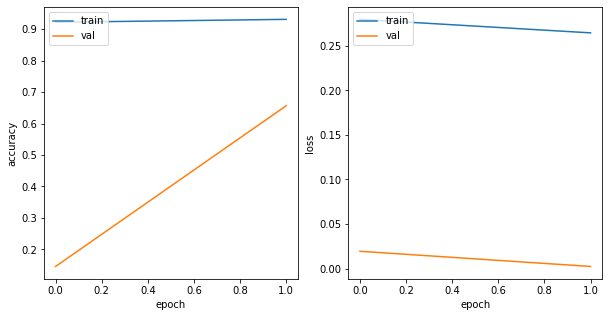

In [31]:
plot_history(resnet50_history)

In [ ]:
resnet50_model.load_weights('D:/DOWNLOADS_EXEC/EuroSAT/NEURALNET/model.weights.best.hdf5')

class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = resnet50_model.predict_generator(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
print("Classification report : ResNet-50")
prf

# Predictions and Evaluting the model

In [33]:
# Save the model and the weights
resnet50_model.save('D:/DOWNLOADS_EXEC/EuroSAT/NEURALNET/ResNet50_eurosat.h5')

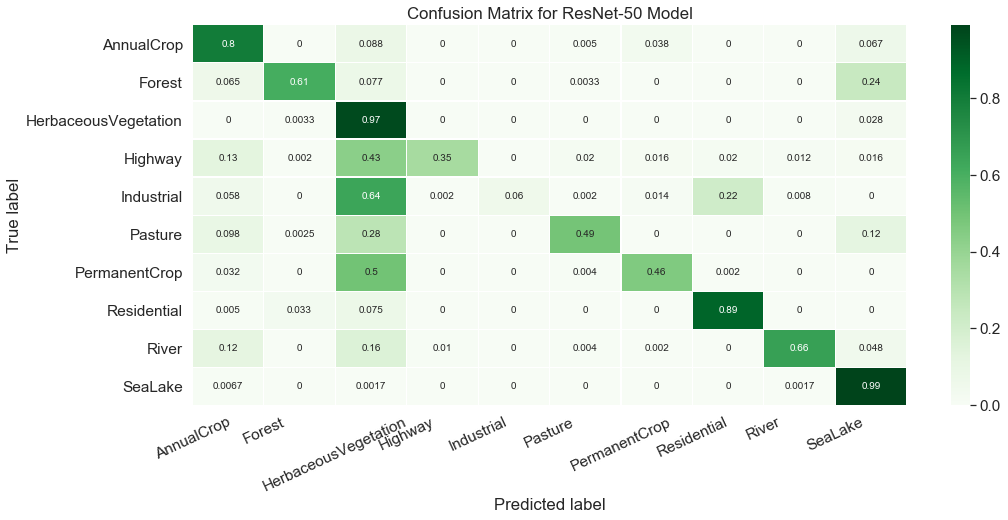

In [36]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(true_classes, predicted_classes)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = LABELS
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for ResNet-50 Model')
plt.show()

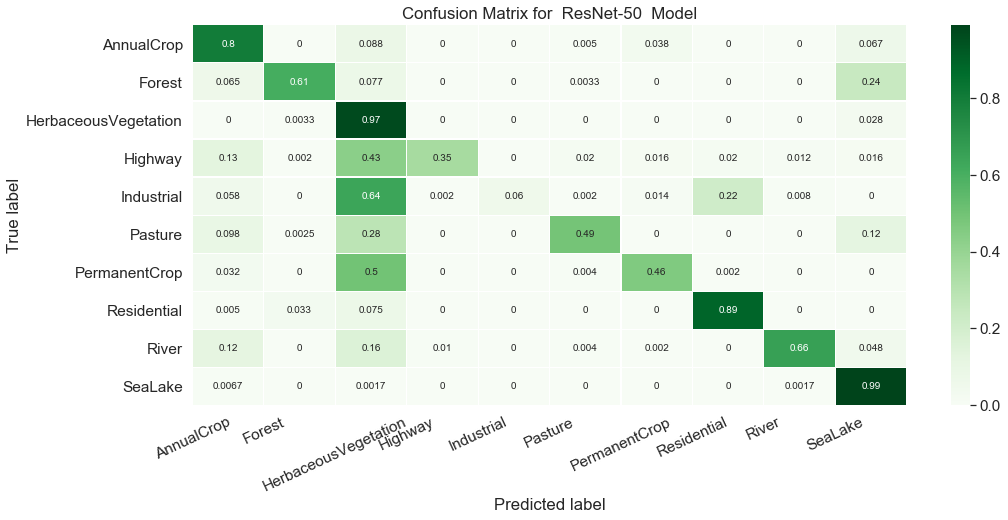

In [37]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(test_generator.classes, predicted_classes)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = LABELS
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for  ResNet-50  Model')
plt.show()